# GP Regression with `scikit-learn`

**GPML(Gaussian Processes for Machine Learning)[1]** is a great book to learn Gaussian Processes.  
However, I found that there aren't many python codes that actually reproduces the examples in the book.(most of them were general-purpose libraries)  
Thus, I wrote a piece of python code(based on the `scikit-learn` library) that reproduces some of the examples in the textbook, so that we can verify the results in the book and play around with the models.

*Disclaimer: I do not own anything. All rights belong to the authors of the GPML book and the scikit-learn library*

## References
[1] GPML(Gaussian Processes for Machine Learning), the MIT Press, 2006  
[2] [sklearn.gaussian_process.GaussianProcessRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html#sklearn.gaussian_process.GaussianProcessRegressor)  
[3] [Gaussian Processes regression: basic introductory example](http://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-noisy-targets-py)    
[4] [Gaussian process regression (GPR) on Mauna Loa CO2 data](http://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-co2-py)

## Contents
1. Importing the necessary libraries
2. Sampling from a Prior
3. GP Regression for Noise-free observations
4. GP Regression for Noisy observations

### 1. Importing the necessary libraries

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, WhiteKernel as WK,\
ExpSineSquared as ESS, RationalQuadratic as RQ, Matern as M

%matplotlib inline

### 2. Sampling from a prior: Figure 2.2 (a) of the GPML

Initial Kernel
1**2 * RBF(length_scale=1)


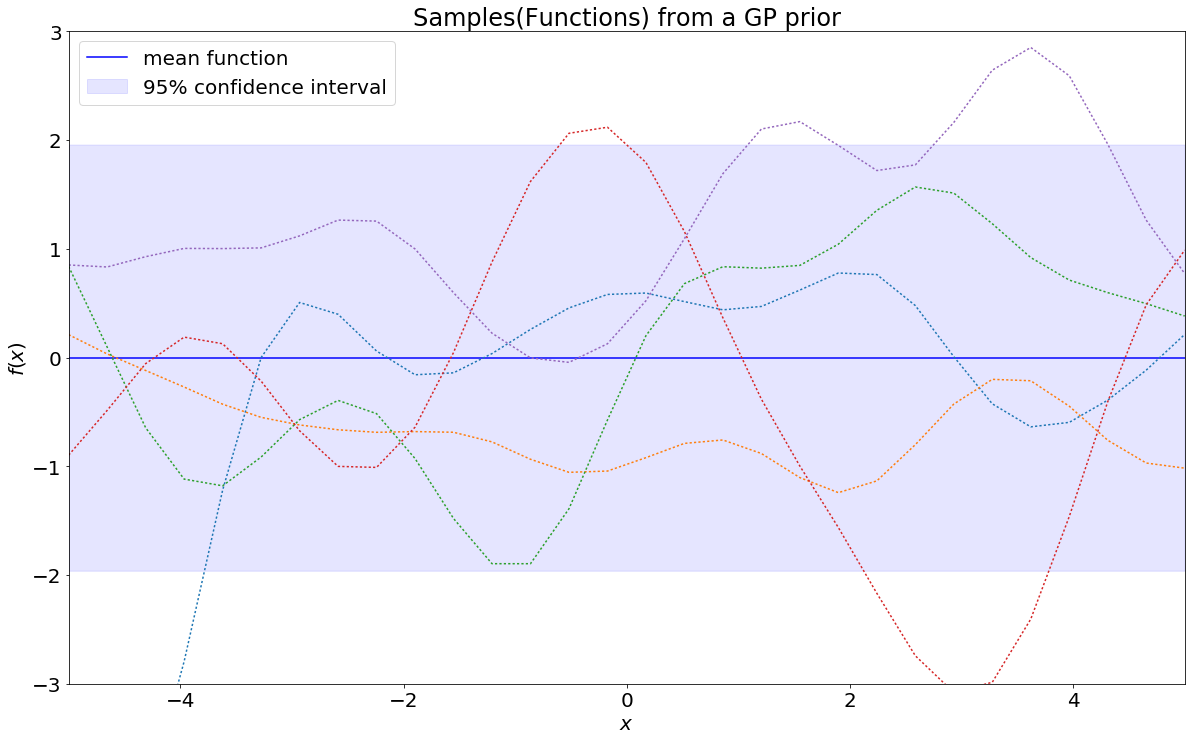

In [2]:
# Specify a GP prior
kernel = 1 * RBF(length_scale = 1)
gp = GPR(kernel = kernel, optimizer = None)
print("Initial Kernel\n%s" % kernel)
X_test = np.array(np.linspace(-5, 5, 1000), ndmin = 2).T
f_mean, f_var = gp.predict(X_test, return_std=True)

# Create a figure
fig_prior = plt.figure(figsize = (20,12))
plt.rcParams.update({'font.size': 20})

# Draw a mean function and 95% confidence interval
plt.plot(X_test, f_mean, 'b-', label='mean function')
upper_bound = f_mean + 1.96 * f_var
lower_bound = f_mean - 1.96 * f_var
plt.fill_between(X_test.ravel(), lower_bound, upper_bound, color = 'b', alpha = 0.1,
                 label='95% confidence interval')

# Draw samples from the posterior and plot
X_samples = np.array(np.linspace(-5, 5, 30), ndmin = 2).T
seed = np.random.randint(10) # random seed
plt.plot(X_samples, gp.sample_y(X_samples, n_samples = 5, random_state = seed), ':')

# Aesthetics
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.xlim(X_test.min(), X_test.max())
plt.ylim(-3, 3)
plt.legend(loc='upper left')
plt.title('Samples(Functions) from a GP prior')
plt.show()

### 3. GP Regression for Noise-free observations: Figure 2.2 (b) of the GPML

In [3]:
# Function to show the summary of the fit
def summary(gp):
    optimized = gp.optimizer != None
    if not optimized:
        s1 = "Fitted Kernel(not optimized)\n\n%s" % gp.kernel_
    else:
        s1 = "Fitted Kernel(Optimized)\n\n%s" % gp.kernel_
    s2 = "\n\nlog marginal likelihood: %.5f" % gp.log_marginal_likelihood(gp.kernel_.theta)
    print(s1 + s2 + '\n')

Fitted Kernel(Optimized)

1.43**2 * RBF(length_scale=0.796)

log marginal likelihood: -8.47455



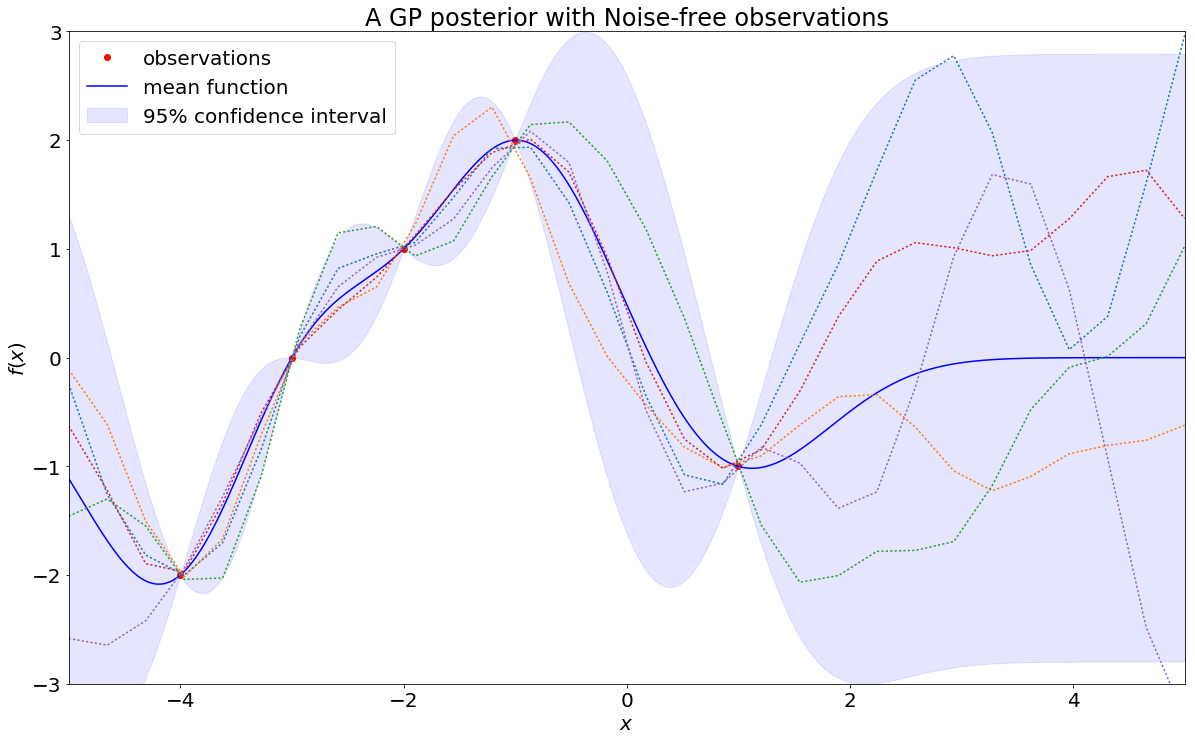

In [4]:
# Specify observations
X_obs = np.array(np.array([-4,-3,-2,-1,1]), ndmin=2).T
f_obs = np.array([-2,0,1,2,-1])

# Specify a kernel
kernel = 1 * RBF(1, (1e-2, 1e2))
gp = GPR(kernel=kernel, alpha = 0, n_restarts_optimizer=9)

# Fit to data & optimize hyperparameters w.r.t. maximizing marginal likelihood
gp.fit(X_obs, f_obs)
summary(gp)

# Make a prediction on several test points
X_test = np.array(np.linspace(-5, 5, 1000), ndmin = 2).T
f_mean, f_var = gp.predict(X_test, return_std=True)

# Create a figure
fig_noise_free = plt.figure(figsize = (20,12))
plt.rcParams.update({'font.size': 20})

# Mark the observations
plt.plot(X_obs, f_obs, 'ro', label='observations')

# Draw a mean function and 95% confidence interval
plt.plot(X_test, f_mean, 'b-', label='mean function')
upper_bound = f_mean + 1.96 * f_var
lower_bound = f_mean - 1.96 * f_var
plt.fill_between(X_test.ravel(), lower_bound, upper_bound, color = 'b', alpha = 0.1,
                 label='95% confidence interval')

# Draw samples from the posterior and plot
X_samples = np.array(np.linspace(-5, 5, 30), ndmin = 2).T
seed = np.random.randint(10) # random seed
plt.plot(X_samples, gp.sample_y(X_samples, n_samples = 5, random_state = seed), ':')

# Aesthetics
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.xlim(X_test.min(), X_test.max())
plt.ylim(-3, 3)
plt.legend(loc='upper left')
plt.title('A GP posterior with Noise-free observations')
plt.show()

### 3. GP Regression for Noisy observations: a diversion from the [Figure 2.2 (b)] of the GPML

#### RBF Kernel

Fitted Kernel(Optimized)

1.36**2 * RBF(length_scale=0.921) + WhiteKernel(noise_level=0.239)

log marginal likelihood: -8.47357



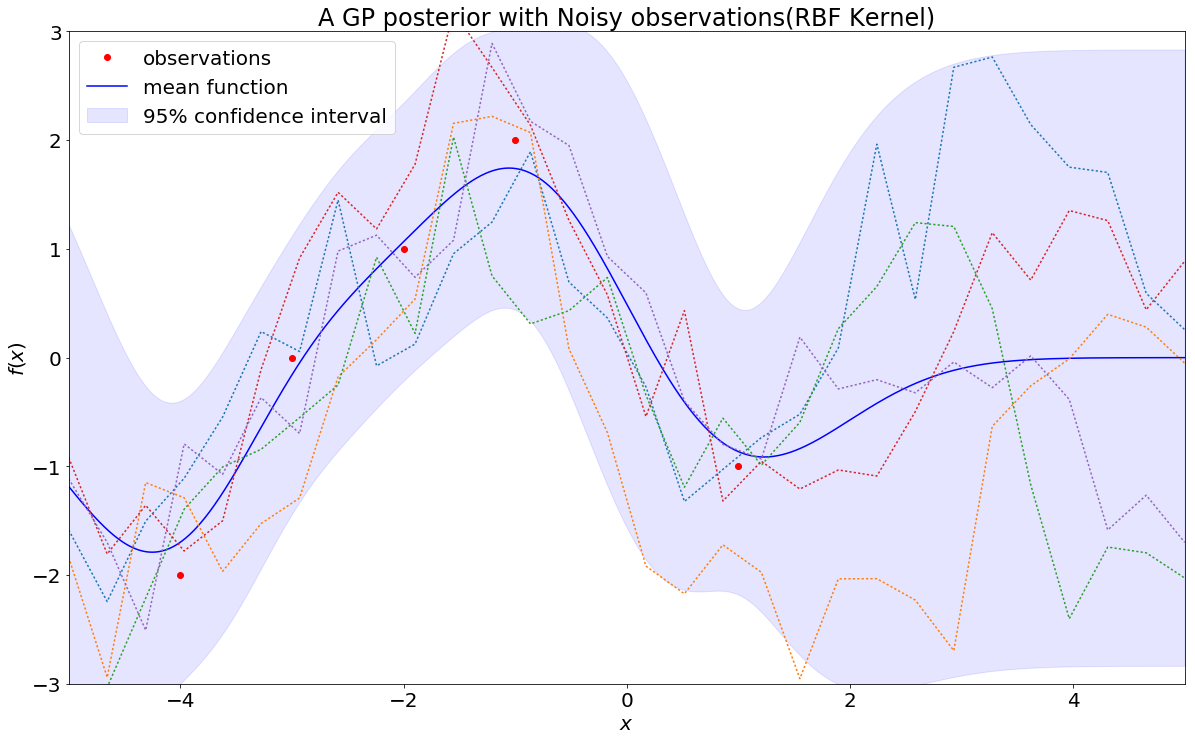

In [5]:
# Specify observations
X_obs = np.array(np.array([-4,-3,-2,-1,1]), ndmin=2).T
f_obs = np.array([-2,0,1,2,-1], dtype='float64')

kernel = 1 * RBF(1, (1e-2, 1e2)) + WK(1)
gp = GPR(kernel=kernel, alpha = 0, n_restarts_optimizer=10)
gp.fit(X_obs, f_obs)
summary(gp)

# Make a prediction on test points
X_test = np.array(np.linspace(-5, 5, 1000), ndmin = 2).T
f_mean, f_var = gp.predict(X_test, return_std=True)

# Create a Plot
fig_noisy = plt.figure(figsize = (20,12))
plt.rcParams.update({'font.size': 20})

# Mark the observations
plt.plot(X_obs, f_obs, 'ro', label='observations')

# Draw a mean function and 95% confidence interval
plt.plot(X_test, f_mean, 'b-', label='mean function')
upper_bound = f_mean + 1.96 * f_var
lower_bound = f_mean - 1.96 * f_var
plt.fill_between(X_test.ravel(), lower_bound, upper_bound, color = 'b', alpha = 0.1,
                 label='95% confidence interval')

# Draw samples from the posterior and plot
X_samples = np.array(np.linspace(-5, 5, 30), ndmin = 2).T
seed = np.random.randint(10) # random seed
plt.plot(X_samples, gp.sample_y(X_samples, n_samples = 5, random_state = seed), ':')

# Aesthetics
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.xlim(-5, 5)
plt.ylim(-3, 3)
plt.legend(loc='upper left')
plt.title('A GP posterior with Noisy observations(RBF Kernel)')
plt.show()

#### Matern Kernel

Fitted Kernel(Optimized)

1.45**2 * Matern(length_scale=0.934, nu=2.5) + WhiteKernel(noise_level=1e-05)

log marginal likelihood: -8.51035



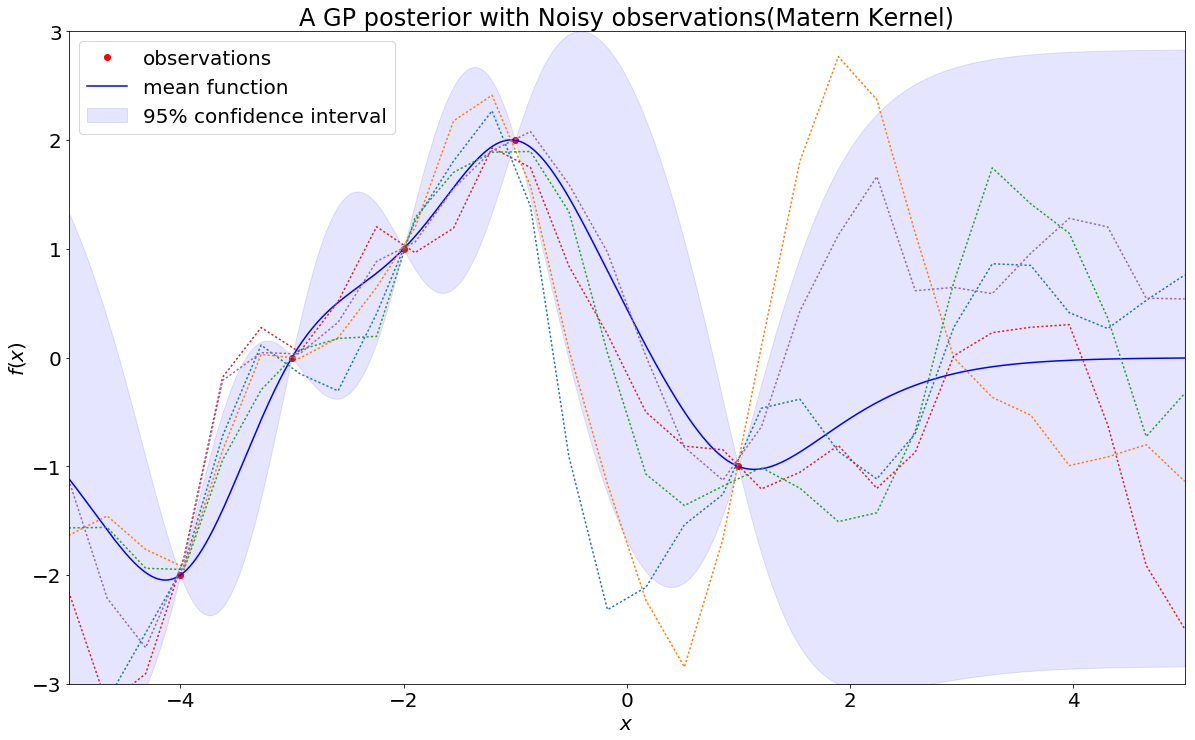

In [6]:
# Specify the Observations
X_obs = np.array(np.array([-4,-3,-2,-1,1]), ndmin=2).T
f_obs = np.array([-2,0,1,2,-1], dtype='float64')

kernel = 1 * M(1, (1e-2, 1e2), nu = 5/2) + WK(1)
gp = GPR(kernel=kernel, alpha = 0, n_restarts_optimizer = 10)
gp.fit(X_obs, f_obs)
summary(gp)

# Make predictions on test points
X_test = np.array(np.linspace(-5, 5, 1000), ndmin = 2).T
f_mean, f_var = gp.predict(X_test, return_std=True)

# Plot
fig_noisy = plt.figure(figsize = (20,12))
plt.rcParams.update({'font.size': 20})

plt.plot(X_obs, f_obs, 'ro', label='observations')

# Draw a mean function and 95% confidence interval
plt.plot(X_test, f_mean, 'b-', label='mean function')
upper_bound = f_mean + 1.96 * f_var
lower_bound = f_mean - 1.96 * f_var
plt.fill_between(X_test.ravel(), lower_bound, upper_bound, color = 'b', alpha = 0.1,
                 label='95% confidence interval')

# Draw samples from the posterior and plot
X_samples = np.array(np.linspace(-5, 5, 30), ndmin = 2).T
seed = np.random.randint(10) # random seed
plt.plot(X_samples, gp.sample_y(X_samples, n_samples = 5, random_state = seed), ':')

# Aesthetics
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.xlim(-5, 5)
plt.ylim(-3, 3)
plt.legend(loc='upper left')
plt.title('A GP posterior with Noisy observations(Matern Kernel)')
plt.show()

## The Manua Loa CO2 Example: Section 5.4.3 of the GPML

### Load the data and preprocess using pandas
- Download the [dataset](http://cdiac.esd.ornl.gov/ftp/trends/co2/maunaloa.co2) and save as maunaloa.co2 in your working directory.
- By the time I'm writing this post, the dataset covers the data from 1958 to 2008.

In [7]:
import pandas as pd
df = pd.read_csv('maunaloa.co2', comment = '*', sep = '\t',
                names = ['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
                           'Aug','Sep', 'Oct', 'Nov', 'Dec', 'Average'])
# convert string values into NaNs by 'coerce' option.
df['Year'] = df['Year'].apply(pd.to_numeric, errors = 'coerce')
df = df[df['Year'].notnull()] # drop NaNs
df.pop('Average') # drop the average co2 values

date = []; co2s = []
for year in range(1958, 2009):
    for month in range(1, 13):
        date.append(year + month/12)
    co2s.append(df.iloc[year - 1958,1:].astype('float64'))

date = np.array(date)
co2 = pd.concat(co2 for co2 in co2s).values

date = date[co2 > 0]
co2 = co2[co2 > 0]

X_obs = np.array(date, ndmin = 2).T
f_obs = co2

### Visual inspection of the observations

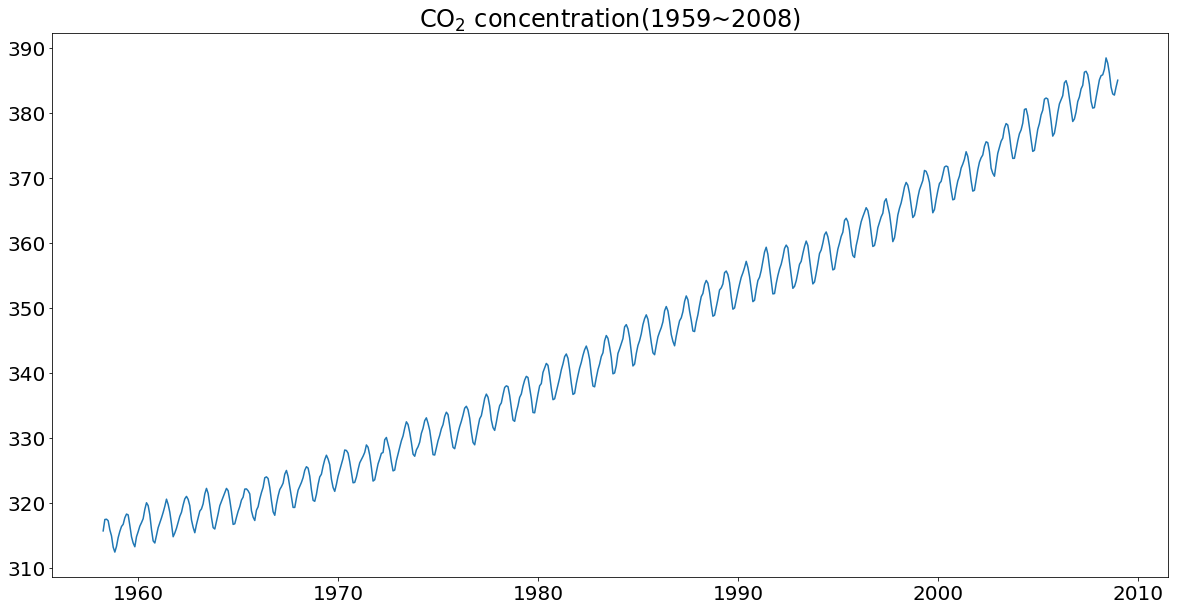

In [8]:
plt.figure(figsize=(20,10))
plt.plot(X_obs,f_obs)
plt.title(r"CO$_2$ concentration(1959~2008)")
plt.show()

### Fitting the GP
WARNING: Fitting this model takes some time, so I used pre-optimized hyperparameter values.

In [9]:
# hyperparameters from the GPML book, where the first element is a dummy
t = [None, 66, 67, 2.4, 90, 1.3, 0.66, 1.2, 0.78, 0.18, 1.6, 0.19]
k1 = t[1]**2 * RBF(length_scale=t[2])  # a long-term rising trend
k2 = t[3]**2 * RBF(length_scale=t[4]) *\
ESS(length_scale=t[5], periodicity=1)  # seasonal variation
k3 = t[6]**2 * RQ(length_scale=t[7], alpha=t[8]) # irregularity
k4 = t[9]**2 * RBF(length_scale=t[10]) + WK(t[11])  # noise
kernel = k1 + k2 + k3 + k4

# Fit without optimization
gp = GPR(kernel=kernel, alpha = 0, optimizer = None, normalize_y = True)
gp.fit(X_obs, f_obs)

# Optimal hyperparameters derived from the past fitting
t_opt = [None, 85.7, 80, 2.4, 174, 1.27, 1.65, 1.06, 0.0112, 0.552, 2.72, 0.0392]
k1_opt = t_opt[1]**2 * RBF(length_scale=t_opt[2])  # a long-term rising trend
k2_opt = t_opt[3]**2 * RBF(length_scale=t_opt[4]) *\
ESS(length_scale=t_opt[5], periodicity=1)  # seasonal variation
k3_opt = t_opt[6]**2 * RQ(length_scale=t_opt[7], alpha=t_opt[8]) # irregularity
k4_opt = t_opt[9]**2 * RBF(length_scale=t_opt[10]) + WK(t_opt[11])  # noise
kernel_opt = k1_opt + k2_opt + k3_opt + k4_opt

gp_opt = GPR(kernel = kernel_opt, alpha = 0, optimizer = None, normalize_y = True)
gp_opt.fit(X_obs, f_obs)

summary(gp)
summary(gp_opt)

Fitted Kernel(not optimized)

66**2 * RBF(length_scale=67) + 2.4**2 * RBF(length_scale=90) * ExpSineSquared(length_scale=1.3, periodicity=1) + 0.66**2 * RationalQuadratic(alpha=0.78, length_scale=1.2) + 0.18**2 * RBF(length_scale=1.6) + WhiteKernel(noise_level=0.19)

log marginal likelihood: -286.27123

Fitted Kernel(not optimized)

85.7**2 * RBF(length_scale=80) + 2.4**2 * RBF(length_scale=174) * ExpSineSquared(length_scale=1.27, periodicity=1) + 1.65**2 * RationalQuadratic(alpha=0.0112, length_scale=1.06) + 0.552**2 * RBF(length_scale=2.72) + WhiteKernel(noise_level=0.0392)

log marginal likelihood: -140.70012



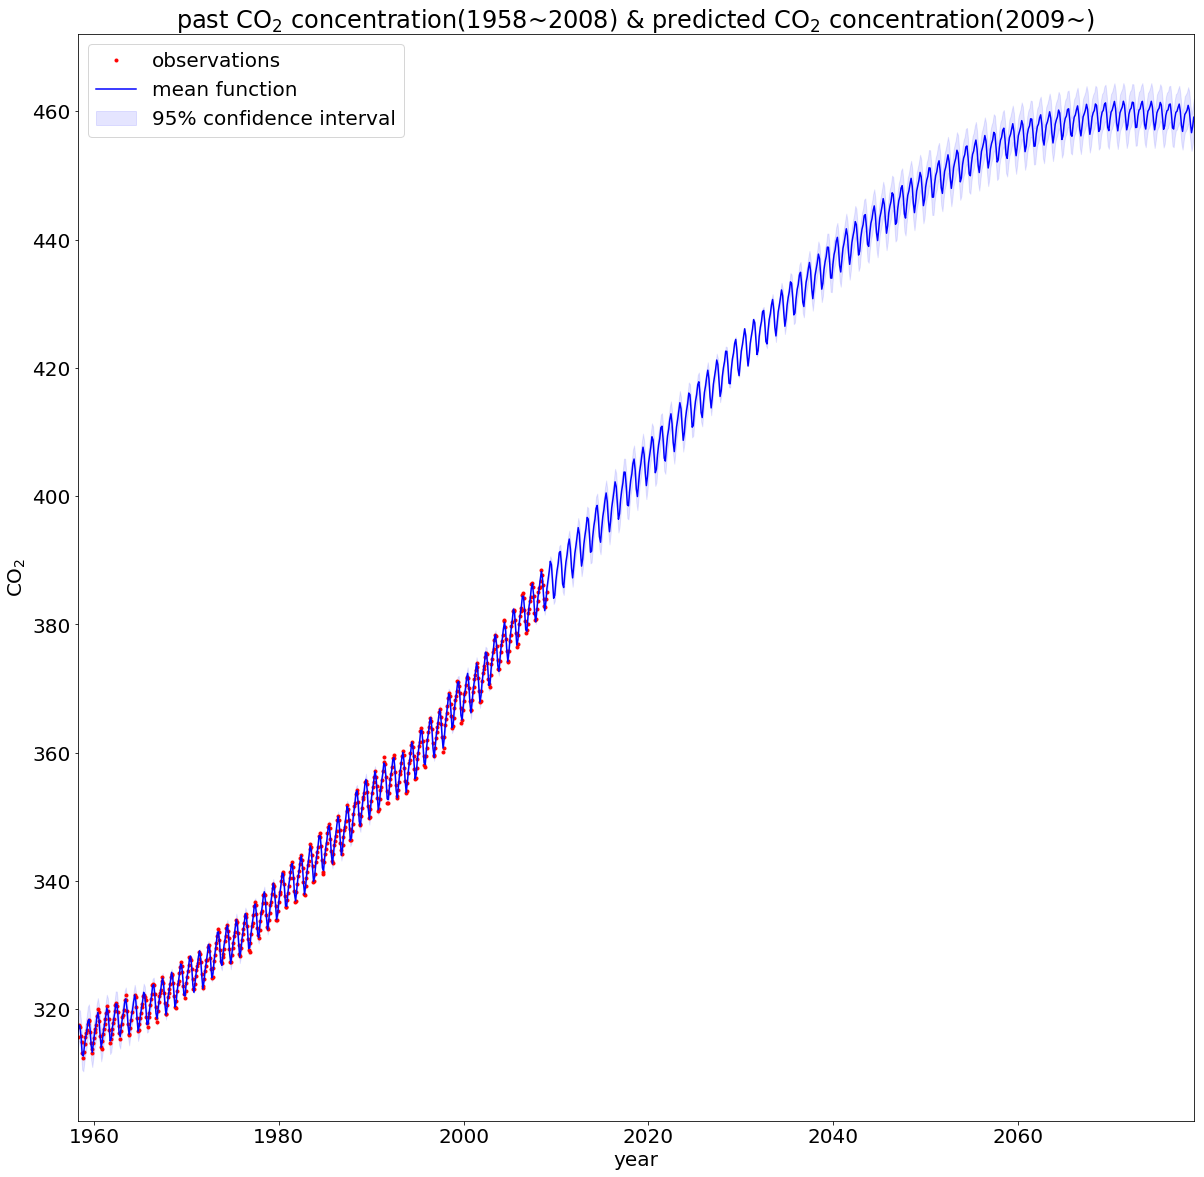

In [10]:
# Predict on future test points
X_test = np.array(np.linspace(X_obs.min(), X_obs.max() + 70, 1000), ndmin = 2).T
f_mean, f_std = gp.predict(X_test, return_std=True)

# Create a figure
fig_co2 = plt.figure(figsize=(20,20))
plt.rcParams.update({'font.size': 20})

# Mark the observations
plt.plot(X_obs, f_obs, 'r.', label='observations')

# Draw a mean function and 95% confidence interval
plt.plot(X_test, f_mean, 'b-', label='mean function')
upper_bound = f_mean + 1.96 * f_var
lower_bound = f_mean - 1.96 * f_var
plt.fill_between(X_test.ravel(), lower_bound, upper_bound, color = 'b', alpha = 0.1,
                 label='95% confidence interval')

# Draw samples from the posterior and plot
plt.xlabel('year')
plt.ylabel(r"CO$_2$")
plt.xlim(X_test.min(), X_test.max())
plt.legend(loc='upper left')
plt.title(r"past CO$_2$ concentration(1958~2008) & predicted CO$_2$ concentration(2009~)")
plt.show()